#  Jet2 case study of Customer Sentiment by Piyush Pande


## **Importing necessary libraries**

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Data Modelling Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#import snowballstemmer

from nltk.corpus import stopwords
import string 
#from nltk.stem import WordNetLemmatizer
import re
import copy

from sklearn.utils import resample

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\piyush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\piyush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\piyush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## glance @ data

In [115]:
raw_df = pd.read_csv('Usecase3_Dataset.csv', encoding='ISO-8859-1')

In [116]:
raw_df.shape

(14640, 3)

In [117]:
raw_df.sample(5)

,airline_sentiment,airline,text
5026,positive,Southwest,@SouthwestAir Although the wait was long due t...
13381,negative,American,@AmericanAir the one at 11:30am? My app still ...
2491,negative,United,@united outsourcing ticket and gate agents at ...
692,neutral,United,@united is flight 587 from DFW to ORD currentl...
18,positive,Virgin America,I â¤ï¸ flying @VirginAmerica. âºï¸ð


In [118]:
raw_df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [119]:
raw_df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Data is imbalance, more no. of negative sentiment are present

In [120]:
df = raw_df[['text', 'airline_sentiment']].copy()
#removed airline name

In [121]:
df.shape

(14640, 2)

In [122]:
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


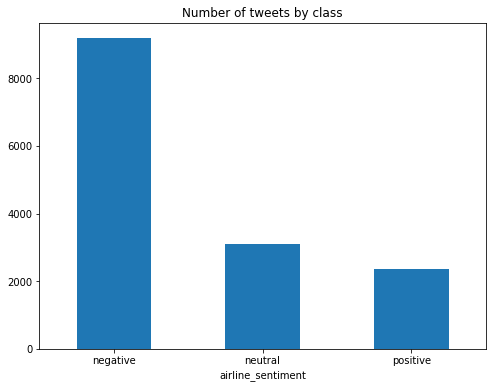

In [123]:
df.groupby(['airline_sentiment']).count().plot(kind='bar', figsize=(8, 6), rot=0, legend=False, title='Number of tweets by class');

# Data Transformation

In [124]:
le = LabelEncoder()
df['target_sentiment'] = le.fit_transform(df['airline_sentiment'])

In [125]:
df.head()

,text,airline_sentiment,target_sentiment
0,@VirginAmerica What @dhepburn said.,neutral,1
1,@VirginAmerica plus you've added commercials t...,positive,2
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0


###  1.1 Load and Prepare dataset 

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 3 columns):
text                 14640 non-null object
airline_sentiment    14640 non-null object
target_sentiment     14640 non-null int32
dtypes: int32(1), object(2)
memory usage: 286.1+ KB


###  **1.2 Check for Class Imbalance**

[Text(0, 0.5, 'Percent')]

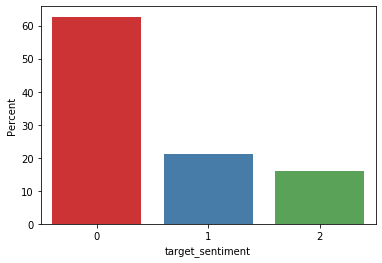

In [127]:
ax = sns.barplot(x="target_sentiment", y="target_sentiment", data=df, 
                 estimator=lambda x: len(x) / len(df) * 100,
                palette="Set1")
ax.set(ylabel="Percent")


# 2.  **Data Visualization**

### 2.1 Distribution of the number of words 

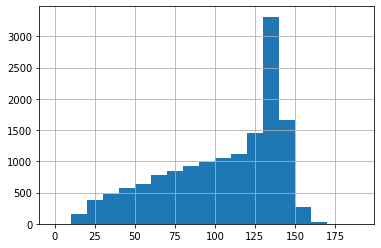

In [128]:
lens = df.text.str.len()
lens.hist(bins = np.arange(0,200,10))

In [129]:
# global variables

SENTIMENT_TO_CODE = {"NEGATIVE": 0,
                     "NEUTRAL": 1,
                     "POSITIVE": 2,
                     "CANT_TELL": 3}
CODE_TO_SENTIMENT = {0: "NEGATIVE",
                     1: "NEUTRAL",
                     2: "POSITIVE",
                     3: "CANT_TELL"}

df

,text,airline_sentiment,target_sentiment
0,@VirginAmerica What @dhepburn said.,neutral,1
1,@VirginAmerica plus you've added commercials t...,positive,2
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1
3,@VirginAmerica it's really aggressive to blast...,negative,0
4,@VirginAmerica and it's a really big bad thing...,negative,0
...,...,...,...
14635,@AmericanAir thank you we got on a different f...,positive,2
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative,0
14637,@AmericanAir Please bring American Airlines to...,neutral,1
14638,"@AmericanAir you have my money, you change my ...",negative,0


# 3.  **Preprocess Data**

In [130]:
stop_words = list(stopwords.words('english'))
wordcloud_stopwords = ['rt','mention','sxsw','link','apple',
                       'store','iphone','ipad','android','google']
stop_words.extend(wordcloud_stopwords)

def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def preprocess(dataframe):
    dataframe['cleaned'] = dataframe['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    dataframe['cleaned'] = dataframe['cleaned'].str.replace('(\w+:\/\/\S+)|^rt|http.+?|[^\w\s]','')
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "@[\w]*")
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "\d*")

    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: nltk.word_tokenize(row))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in stop_words])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in string.punctuation])
    
    lemmatizer = WordNetLemmatizer()
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join(x))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
    return dataframe 

train_p = preprocess(df) 
test_p  = preprocess(df) 
#drop.df['target']

In [131]:
train_p.head()

,text,airline_sentiment,target_sentiment,cleaned
0,@VirginAmerica What @dhepburn said.,neutral,1,virginamerica dhepburn said
1,@VirginAmerica plus you've added commercials t...,positive,2,virginamerica plus youve added commercial expe...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1,virginamerica didnt today must mean need take ...
3,@VirginAmerica it's really aggressive to blast...,negative,0,virginamerica really aggressive blast obnoxiou...
4,@VirginAmerica and it's a really big bad thing...,negative,0,virginamerica really big bad thing


# 4.  **Plot Data**


In [132]:
sent_NEG=train_p[train_p.airline_sentiment == SENTIMENT_TO_CODE["NEGATIVE"]]
sent_NEU=train_p[train_p.airline_sentiment == SENTIMENT_TO_CODE["NEUTRAL"]]
sent_POS=train_p[train_p.airline_sentiment == SENTIMENT_TO_CODE["POSITIVE"]]
sent_CNT=train_p[train_p.airline_sentiment == SENTIMENT_TO_CODE["CANT_TELL"]]

# 5. Feature Engineering

In [133]:

def feature_engineering(df):
    
    punctuation = string.punctuation
  
    # number of punctuations
    df['num_punc'] = df['text'].apply(lambda tweet_msg: len([punct for punct in tweet_msg if punct in punctuation]))

    # Finding the number of words in the headline
    df['num_words'] = df['text'].apply(lambda tweet_msg: len(tweet_msg.split()))

    # the unique number of words in the headline
    df['num_unique_words'] = df['text'].apply(lambda tweet_msg: len(set(tweet_msg.split())))

    # the number of characters in the headline
    df['num_chars'] = df['text'].apply(lambda tweet_msg: len(tweet_msg))

    # number of genuine words with no stopwords  
    df['num_words_nostop'] = df['text'].apply(lambda tweet_msg: len([word for word in tweet_msg.split() if word not in stop_words]))

    # number of stopwords
    df['num_stop_words'] = df['num_words'] - df['num_words_nostop']

    return df

In [134]:
train_fe = feature_engineering(df)
test_fe = feature_engineering(df)
print("train_fe.shape: ",train_fe.shape,"\n"\
      "test_fe.shape: ",test_fe.shape)

train_fe.shape:  (14640, 10) 
test_fe.shape:  (14640, 10)


In [135]:
train_fe.head(3)

,text,airline_sentiment,target_sentiment,cleaned,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop_words
0,@VirginAmerica What @dhepburn said.,neutral,1,virginamerica dhepburn said,3,4,4,35,4,0
1,@VirginAmerica plus you've added commercials t...,positive,2,virginamerica plus youve added commercial expe...,6,9,9,72,6,3
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1,virginamerica didnt today must mean need take ...,6,12,11,71,10,2


In [136]:
test_fe.head(3)

,text,airline_sentiment,target_sentiment,cleaned,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop_words
0,@VirginAmerica What @dhepburn said.,neutral,1,virginamerica dhepburn said,3,4,4,35,4,0
1,@VirginAmerica plus you've added commercials t...,positive,2,virginamerica plus youve added commercial expe...,6,9,9,72,6,3
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1,virginamerica didnt today must mean need take ...,6,12,11,71,10,2


# 6. **Model Building**

In [137]:
df.head()

,text,airline_sentiment,target_sentiment,cleaned,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop_words
0,@VirginAmerica What @dhepburn said.,neutral,1,virginamerica dhepburn said,3,4,4,35,4,0
1,@VirginAmerica plus you've added commercials t...,positive,2,virginamerica plus youve added commercial expe...,6,9,9,72,6,3
2,@VirginAmerica I didn't today... Must mean I n...,neutral,1,virginamerica didnt today must mean need take ...,6,12,11,71,10,2
3,@VirginAmerica it's really aggressive to blast...,negative,0,virginamerica really aggressive blast obnoxiou...,7,17,17,126,11,6
4,@VirginAmerica and it's a really big bad thing...,negative,0,virginamerica really big bad thing,2,10,10,55,5,5


# train test split

In [155]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned'].values, df['target_sentiment'].values, test_size=0.30, random_state=0)

In [156]:
def tokenize(s): 
    tokens = re_tok.sub(r' \1 ', s).split()
    return stemmer.stemWords(tokens)

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
stemmer = snowballstemmer.EnglishStemmer()
    
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.75, min_df=3, sublinear_tf=True)

In [157]:
tfidf_train = vect.fit_transform(X_train)
tfidf_test = vect.transform(X_test)

In [158]:
scores = cross_val_score(LogisticRegression(C=10, dual=True), tfidf_train, y_train, cv=5)

In [159]:
scores

array([0.78780488, 0.77804878, 0.77756098, 0.77306003, 0.78965349])

In [160]:
np.mean(scores), np.std(scores)

(0.7812256305871991, 0.006395536263017365)

# 7. TESTING

In [161]:
m = LogisticRegression(C=10, dual=True)
m.fit(tfidf_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=True, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [162]:
preds = m.predict(tfidf_test)
(preds==y_test).mean()
preds

array([0, 0, 0, ..., 0, 0, 1])

In [163]:
print(metrics.classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2788
           1       0.61      0.52      0.56       919
           2       0.75      0.61      0.67       685

    accuracy                           0.78      4392
   macro avg       0.73      0.68      0.70      4392
weighted avg       0.77      0.78      0.77      4392

